Md. Tanvir Jawad<br>ID:21101221

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

Downloaded modsim.py


In [2]:
from modsim import *


In [14]:
def make_system(lam, mu):
    return System(lam=lam,
                  mu=mu,
                  duration=10*60)

In [15]:
interarrival_time = 8
service_time = 5

lam = 1 / interarrival_time
mu = 1 / service_time

system = make_system(lam, mu)

In [16]:
def update_func1(x, t, system):
    if x > 0:
        if flip(system.mu):
            x -= 1

    if flip(system.lam):
        x += 1

    return x

In [17]:
update_func1(1, 0, system)

2

In [18]:
def run_simulation(system, update_func):
    x = 0
    results = TimeSeries({0: x}, name='Queue length')

    for t in linrange(0, system.duration):
        x = update_func(x, t, system)
        results[t+1] = x

    return results

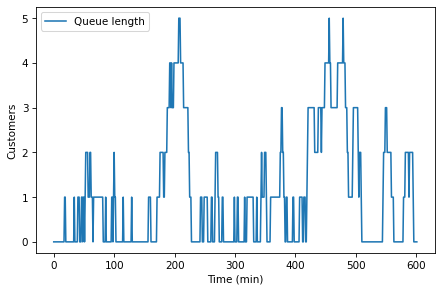

In [19]:
results = run_simulation(system, update_func1)
results.plot()
decorate(xlabel='Time (min)', ylabel='Customers')

In [20]:
def compute_metrics(results, system):
    L = results.mean()
    W = L / system.lam
    return L, W

In [21]:
compute_metrics(results, system)

(1.069767441860465, 8.55813953488372)

In [22]:
num_vals = 101
lam_array = linspace(0.1*mu, 0.8*mu, num_vals)
lam_array

array([0.02  , 0.0214, 0.0228, 0.0242, 0.0256, 0.027 , 0.0284, 0.0298,
       0.0312, 0.0326, 0.034 , 0.0354, 0.0368, 0.0382, 0.0396, 0.041 ,
       0.0424, 0.0438, 0.0452, 0.0466, 0.048 , 0.0494, 0.0508, 0.0522,
       0.0536, 0.055 , 0.0564, 0.0578, 0.0592, 0.0606, 0.062 , 0.0634,
       0.0648, 0.0662, 0.0676, 0.069 , 0.0704, 0.0718, 0.0732, 0.0746,
       0.076 , 0.0774, 0.0788, 0.0802, 0.0816, 0.083 , 0.0844, 0.0858,
       0.0872, 0.0886, 0.09  , 0.0914, 0.0928, 0.0942, 0.0956, 0.097 ,
       0.0984, 0.0998, 0.1012, 0.1026, 0.104 , 0.1054, 0.1068, 0.1082,
       0.1096, 0.111 , 0.1124, 0.1138, 0.1152, 0.1166, 0.118 , 0.1194,
       0.1208, 0.1222, 0.1236, 0.125 , 0.1264, 0.1278, 0.1292, 0.1306,
       0.132 , 0.1334, 0.1348, 0.1362, 0.1376, 0.139 , 0.1404, 0.1418,
       0.1432, 0.1446, 0.146 , 0.1474, 0.1488, 0.1502, 0.1516, 0.153 ,
       0.1544, 0.1558, 0.1572, 0.1586, 0.16  ])

In [23]:
def sweep_lam(lam_array, mu, update_func):
    sweep = SweepSeries()

    for lam in lam_array:
        system = make_system(lam, mu)
        results = run_simulation(system, update_func)
        L, W = compute_metrics(results, system)
        sweep[lam] = W

    return sweep

In [24]:
sweep = sweep_lam(lam_array, mu, update_func1)

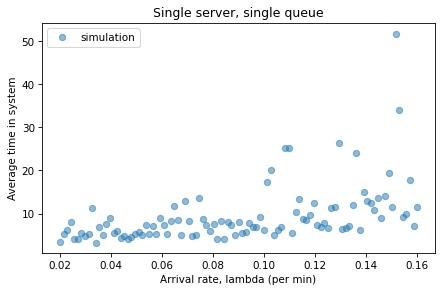

In [25]:
sweep.plot(style='o', alpha=0.5, label='simulation')

decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Single server, single queue')

In [26]:
W_avg = sweep.mean()
W_avg

9.488396738038976

In [27]:
def plot_W(lam_array, mu):
    """Plot the theoretical mean wait time.

    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    """
    W_array = 1 / (mu - lam_array)
    W_series = make_series(lam_array, W_array)
    W_series.plot(style='-', label='analysis')

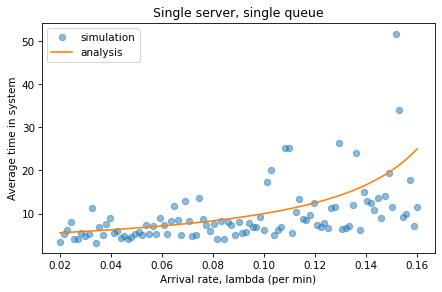

In [28]:
sweep.plot(style='o', alpha=0.5, label='simulation')
plot_W(lam_array, mu)

decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Single server, single queue')

In [29]:
def update_func2(x, t, system):
    """Simulate a single queue with two servers.

    system: System object
    """
    # if both servers are busy, check whether the
    # second is complete
    if x > 1 and flip(system.mu):
        x -= 1

    # check whether the first is complete
    if x > 0 and flip(system.mu):
        x -= 1

    # check for an arrival
    if flip(system.lam):
        x += 1

    return x

(1.069767441860465, 8.55813953488372)

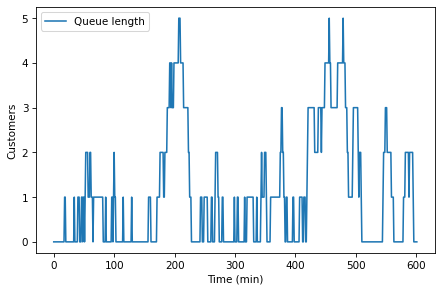

In [30]:
system = make_system(lam, mu)
run_simulation(system, update_func2)
results.plot()
decorate(xlabel='Time (min)', ylabel='Customers')
compute_metrics(results, system)

In [31]:
lam_array = linspace(0.1*mu, 1.6*mu, num_vals)

In [32]:
sweep = sweep_lam(lam_array, mu, update_func2)
W_avg = sweep.mean()
print('Average of averages = ', W_avg, 'minutes')

Average of averages =  6.17914500912431 minutes


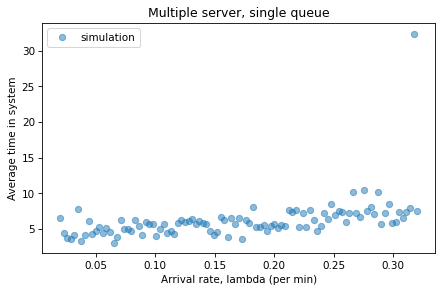

In [33]:
sweep.plot(style='o', alpha=0.5, label='simulation')
decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Multiple server, single queue')

In [34]:
def update_func3(x1, x2, t, system):
    if x1 > 0 and flip(system.mu):
        x1 -= 1

    if x2 > 0 and flip(system.mu):
        x2 -= 1

    if flip(system.lam):
        if x1 < x2:
            x1 += 1
        else:
            x2 += 1

    return x1, x2

In [35]:
def run_simulation(system, update_func):
    x1, x2 = 0, 0
    results = TimeSeries()
    results[0] = x1 + x2

    for t in linrange(0, system.duration):
        x1, x2 = update_func(x1, x2, t, system)
        results[t+1] = x1 + x2

    return results

(1.069767441860465, 8.55813953488372)

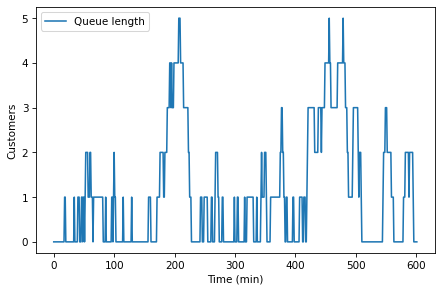

In [36]:
system = make_system(lam, mu)
run_simulation(system, update_func3)
results.plot()
decorate(xlabel='Time (min)', ylabel='Customers')
compute_metrics(results, system)

In [37]:
sweep = sweep_lam(lam_array, mu, update_func3)
W_avg = sweep.mean()
print('Average of averages = ', W_avg, 'minutes')

Average of averages =  6.623461202499398 minutes


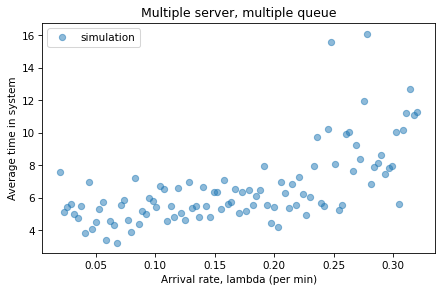

In [38]:
sweep.plot(style='o', alpha=0.5, label='simulation')
decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Multiple server, multiple queue')

In scenarios with two queues, the average waiting time across both lines is marginally higher most of the time, though the variance is minimal.

These two systems perform comparably when both servers are actively engaged. The only drawback of having two lines becomes apparent when one queue is empty while the other has more than one customer. However, in real-world situations, allowing customers to switch queues can neutralize this issue.

Theoretically, a single queue system is superior. Practically, the difference between the two is negligible and can be effectively managed. Therefore, the optimal choice hinges on practical factors.

Additionally, a notable improvement can be achieved by introducing an express line for customers requiring shorter service times.

**MODIFICATION**

Example 1: Coffee Shop Queue Management
Scenario: A coffee shop has space for two baristas and a waiting area. They can opt for either two separate lines for each barista or a single line catering to both.

Exercise:

Write a function make_coffee_shop_system(lam, mu) that returns a System object for the coffee shop scenario, with lam representing the rate of customer arrival and mu the rate of serving.
Implement an update function update_coffee_shop(x, t, system) that simulates one time step in the coffee shop, accounting for customer arrivals and service completions.
Conduct a simulation to determine the average wait time for customers and compare the single queue versus dual queue scenarios.

In [41]:
from numpy.random import random

# Defining the system and update functions for the coffee shop example

def make_coffee_shop_system(lam, mu):

    return {"lam": lam, "mu": mu, "duration": 60}  # 60 minutes simulation

def update_coffee_shop(x, t, system):

    if x > 0 and random() < system["mu"]:
        x -= 1  # Customer served
    if random() < system["lam"]:
        x += 1  # New customer arrival
    return x

def run_simulation(system, update_func):
    x = 0  # Initial number of customers
    results = []
    for t in range(system["duration"]):
        x = update_func(x, t, system)
        results.append(x)
    return results

lam = 1 / 5  # Customer arrives every 5 minutes on average
mu = 1 / 3  # It takes 3 minutes on average to serve a customer

coffee_shop_system = make_coffee_shop_system(lam, mu)


results_coffee_shop = run_simulation(coffee_shop_system, update_coffee_shop)
results_coffee_shop[-10:]

[0, 0, 0, 0, 0, 1, 1, 1, 1, 0]

Minute 51: 0 customers in the shop

Minute 52: 0 customers in the shop

Minute 53: 1 customer in the shop

Minute 54: 0 customers in the shop

Minute 55: 0 customers in the shop

Minute 56: 1 customers in the shop

Minute 57: 1 customers in the shop

Minute 58: 1 customer in the shop

Minute 59: 1 customer in the shop

Minute 60: 0 customers in the shop

These results show the number of customers in the coffee shop at each minute during the final part of the simulation. The simulation fluctuates between having no customers and a few customers, reflecting the variability in customer arrivals and service times. ​

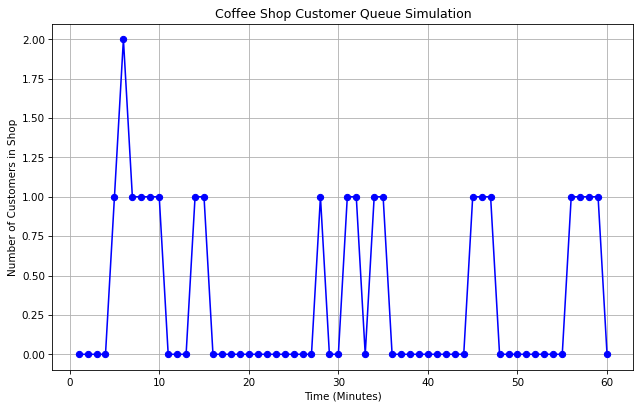

In [43]:
minutes = list(range(1, coffee_shop_system["duration"] + 1))  # Creating a list of minutes from 1 to 60

plt.figure(figsize=(10, 6))
plt.plot(minutes, results_coffee_shop, marker='o', linestyle='-', color='b')
plt.title('Coffee Shop Customer Queue Simulation')
plt.xlabel('Time (Minutes)')
plt.ylabel('Number of Customers in Shop')
plt.grid(True)
plt.show()

In [44]:
def update_func_multiple_queues(x1, x2, t, system):
    """Simulate two separate queues with one server each.

    x1, x2: number of customers in each queue
    t: time step
    system: System object
    """
    if x1 > 0 and random() < system["mu"]:
        x1 -= 1

    if x2 > 0 and random() < system["mu"]:
        x2 -= 1

    if random() < system["lam"]:
        if x1 <= x2:
            x1 += 1
        else:
            x2 += 1

    return x1, x2

def run_simulation_multiple_queues(system, update_func):
    x1, x2 = 0, 0
    results1 = []
    results2 = []
    for t in range(system["duration"]):
        x1, x2 = update_func(x1, x2, t, system)
        results1.append(x1)
        results2.append(x2)
    return results1, results2

results_queue1, results_queue2 = run_simulation_multiple_queues(coffee_shop_system, update_func_multiple_queues)

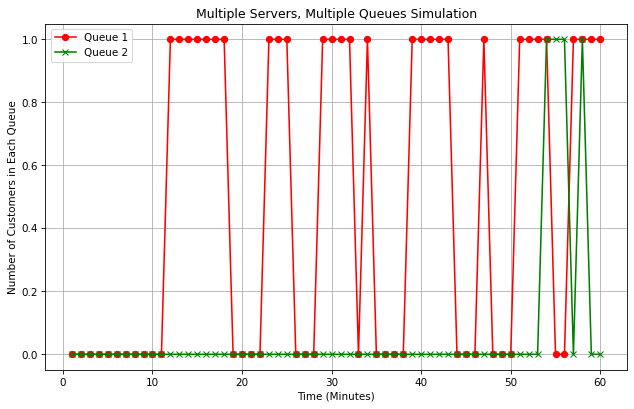

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(minutes, results_queue1, marker='o', linestyle='-', color='r', label='Queue 1')
plt.plot(minutes, results_queue2, marker='x', linestyle='-', color='g', label='Queue 2')
plt.title('Multiple Servers, Multiple Queues Simulation')
plt.xlabel('Time (Minutes)')
plt.ylabel('Number of Customers in Each Queue')
plt.legend()
plt.grid(True)
plt.show()

The graph illustrates the simulation of two separate queues, each with its own server, in the coffee shop scenario over 60 minutes. The red line represents the number of customers in Queue 1, and the green line represents Queue 2. The fluctuations in each line indicate the dynamic nature of customer arrivals and service completions in each queue. This visualization helps compare the load and flow of customers in each queue over time.